In [9]:
import pandas as pd 
df= pd.read_csv('clustering_data.csv')
df

,video_id,tags,category,category_id,combined_embedding
0,RswkyHO6zkM,g n n k b l e v c e r e n n c e r n k b l e c ...,Film & Animation,1,"[-0.8094359636, -0.4726789594, -0.2782412767, ..."
1,0ZgwrIlBf2U,r l e r f u l l v e r l e r n e w r l e r r l ...,Film & Animation,1,"[-0.9190508723, -0.6291724443, -0.8364736438, ..."
2,rF4y8Z10-PI,h e e q u l z e r h e e q u l z e r c e n e h ...,Film & Animation,1,"[-0.8471205831, -0.5587693453, -0.5335170031, ..."
3,UrRZ-kKnBEw,h e p r n c e b r e r c l e x b l l c r l,Film & Animation,1,"[-0.8086147308, -0.4953981936, -0.9000739455, ..."
4,jc0ZcR8ozjE,n ı k k k u u n ı k k k u u z ö z g e ö z p r ...,Film & Animation,1,"[-0.8515130877, -0.4386580586, -0.6855377555, ..."
...,...,...,...,...,...
7723,s5UarLR8SmE,h e l h l r e c p e h e l h l r e c p e f r w ...,Education,27,"[-0.7333920002, -0.4133580029, -0.2094023079, ..."
7724,M7pMtxicaVU,l u n c h r e c p e n n l u n c h r e c p e f ...,Education,27,"[-0.7407260537, -0.4115942121, -0.5249691606, ..."
7725,28Du9nIQwBM,k n c r e l u n n u r l k n c r e k n c r e h ...,Education,27,"[-0.7899497151, -0.3439107537, -0.3350068927, ..."
7726,Ecc7SHqymPo,r e u c b l e l n e r f f e r e n l e q u n f ...,Education,27,"[-0.777256906, -0.5230876207, -0.9335253239, 0..."


In [35]:
df = df.drop_duplicates(subset='video_id', keep='first')


In [10]:
import numpy as np

def get_video_embeddings(video_ids):
    embeddings = []
    for video_id in video_ids:
        # Check if the video_id exists in the dataframe
        if video_id in df['video_id'].values:
            # Append the corresponding embedding to the list
            embedding = df.loc[df['video_id'] == video_id, 'combined_embedding'].values[0]
            embeddings.append(embedding)
        else:
            # If the video_id is not found, append None or handle the missing video
            embeddings.append(None)  # You can modify this based on how you want to handle missing videos
    # Convert the list of embeddings into a numpy array suitable for LSTM input
    return np.array(embeddings)

# Example usage
video_ids = ['UrRZ-kKnBEw', 'RswkyHO6zkM', 'jc0ZcR8ozjE', 'M7pMtxicaVU', '28Du9nIQwBM']  # List of 5 video_ids
embeddings = get_video_embeddings(video_ids)

print(len(embeddings))


5


In [39]:
df['video_id'].values[50:60]

array(['ZiULxLLP32s', 'Aw6GkiCvcWs', '_K0sfcUp3ew', 'NfZ96LgkCUI',
       'LITlLW9bYNs', 'rn6R4ncd2OU', 'AuRv0Vu55nA', 'kTny1iFuTh0',
       '-JP-zoBLyWE', '7iBig24hXg8'], dtype=object)

In [62]:
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
def create_model(input_dim):
    model = Sequential([
        LSTM(128, input_shape=(1, input_dim), return_sequences=False),
        Dense(input_dim, activation='linear')  # Output same dimension as input embeddings
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
    return model

def get_video_embeddings(video_ids, df):
    embeddings = []
    
    for video_id in video_ids:
        if video_id in df['video_id'].values:
            embedding = df[df['video_id'] == video_id]['combined_embedding'].iloc[0]

            embedding_array = np.array(ast.literal_eval(embedding))

            # Now reshape the array to (768, 1)
            embedding = embedding_array.reshape(768,)
            
            if len(embedding) > 0:
                # Check the shape of the individual embedding
                # print(f"Embedding for video_id {video_id}: {embedding.shape}")  # Debugging the shape of each embedding
                
                # Ensure that embedding is a 1D array of length 768
                if embedding.shape != (768,):
                    print(f"Warning: Embedding for video_id {video_id} has unexpected shape {embedding.shape}.")
                    embedding = np.ones(768)  # Replace with zero vector if shape is not (768,)
                
                embeddings.append(embedding)
            else:
                print(f"Embedding not found for video_id {video_id}.")
                embeddings.append(np.zeros(768))  # If embedding is missing, append zero vector
        else:
            print(f"Video ID {video_id} not found in DataFrame.")
            embeddings.append(np.ones(768))  # If video_id not found, append zero vector
    
    embeddings = np.array(embeddings)

    # Check if embeddings has the correct shape
    print("Embeddings shape after extraction:", embeddings.shape)  # Should be (N, 768)

    # Validate that embeddings have the correct shape
    if embeddings.shape[1] != 768:
        raise ValueError(f"Expected embedding dimension of 768, but got {embeddings.shape[1]}.")

    return embeddings

# Iteratively update embeddings
def iterative_embedding_update(model, embeddings, alpha=0.5):
    current_embedding = embeddings[0]  # Always start with the first embedding
    print("Initial embedding:", current_embedding[:10])  # Debug: Print first 10 values of initial embedding
    for i in range(1, len(embeddings)):
        input_embedding = current_embedding.reshape(1, 1, -1)  # Reshape for LSTM input
        predicted_embedding = model.predict(input_embedding)
        # Update the embedding using a weighted average of prediction and next embedding
        current_embedding = alpha * predicted_embedding[0] + (1 - alpha) * embeddings[i]
    return current_embedding


import random

# Assuming these are the video IDs
video_ids =['ZiULxLLP32s', 'Aw6GkiCvcWs', 'NfZ96LgkCUI',
       'LITlLW9bYNs', 'rn6R4ncd2OU', 'AuRv0Vu55nA', 'kTny1iFuTh0',
       '-JP-zoBLyWE']


# Assuming df is already defined and contains video IDs and combined embeddings
embeddings = get_video_embeddings(video_ids, df)

# Verify embedding dimensions
print("Embeddings shape:", embeddings.shape)  # Should be (5, 768)

# Create the model
embedding_dim = embeddings.shape[1]  # This should be 768
lstm_model = create_model(embedding_dim)

# Training and showing embeddings after each epoch
print("Initial embedding:", embeddings[0][:10])  # Show the first embedding before training

# First epoch: Train to match the first embedding
initial_embedding = embeddings[0].reshape(1, 1, -1)
target_embedding = embeddings[1].reshape(1, -1)
loss = lstm_model.train_on_batch(initial_embedding, target_embedding)
print(f"Step 1: Loss = {loss:.4f}")
# print(f"Embedding after Step 1: {model.predict(initial_embedding).flatten()[:10]}")  # First prediction

lstm_losses = []



# Iteratively train on the rest of the sequence
for epoch in range(1, 10):  # Reduced epochs for demonstration
    print(f"Epoch {epoch + 1}")
    epoch_loss = 0
    for i in range(len(embeddings) - 1):  # Train on pairs
        input_embedding = embeddings[i].reshape(1, 1, -1)
        target_embedding = embeddings[i + 1].reshape(1, -1)
        loss = lstm_model.train_on_batch(input_embedding, target_embedding)
        epoch_loss += loss
        print(f"Step {i + 1}: Loss = {loss:.4f}")
        # Print updated embedding after each step in the epoch
    lstm_losses.append(epoch_loss / (len(embeddings) - 1))  # Average loss for    # print(f"Embedding after Step {i + 1}: {model.predict(input_embedding).flatten()[:10]}")

# After training, print final embedding
final_embedding_lstm = iterative_embedding_update(lstm_model, embeddings, alpha=0.7)
print("Final updated embedding shape:", final_embedding_lstm.shape)
print("Final updated embedding (sample):", final_embedding_lstm[:10])  # Display first 10 values


Embeddings shape after extraction: (8, 768)
Embeddings shape: (8, 768)


c:\Users\Bhupesh\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Initial embedding: [-0.82950544 -0.61796957 -0.81665689  0.62184167  0.39326617 -0.111754
  0.66116905  0.48385939 -0.59297299 -0.99998939]
Step 1: Loss = 0.3701
Epoch 2
Step 1: Loss = 0.3547
Step 2: Loss = 0.3161
Step 3: Loss = 0.3069
Step 4: Loss = 0.2855
Step 5: Loss = 0.2679
Step 6: Loss = 0.2653
Step 7: Loss = 0.2494
Epoch 3
Step 1: Loss = 0.2368
Step 2: Loss = 0.2246
Step 3: Loss = 0.2119
Step 4: Loss = 0.1991
Step 5: Loss = 0.1917
Step 6: Loss = 0.1834
Step 7: Loss = 0.1741
Epoch 4
Step 1: Loss = 0.1658
Step 2: Loss = 0.1600
Step 3: Loss = 0.1521
Step 4: Loss = 0.1451
Step 5: Loss = 0.1418
Step 6: Loss = 0.1373
Step 7: Loss = 0.1324
Epoch 5
Step 1: Loss = 0.1281
Step 2: Loss = 0.1246
Step 3: Loss = 0.1202
Step 4: Loss = 0.1159
Step 5: Loss = 0.1139
Step 6: Loss = 0.1117
Step 7: Loss = 0.1088
Epoch 6
Step 1: Loss = 0.1064
Step 2: Loss = 0.1042
Step 3: Loss = 0.1013
Step 4: Loss = 0.0985
Step 5: Loss = 0.0973
Step 6: Loss = 0.0959
Step 7: Loss = 0.0938
Epoch 7
Step 1: Loss = 0.092

(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Cosine similarity for step 1: 0.9587
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Cosine similarity for step 2: 0.9408
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Cosine similarity for step 3: 0.9906
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Cosine similarity for step 4: 0.9932
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cosine similarity for step 5: 0.9132
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Cosine similarity for step 6: 0.9671
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Cosine similarity for step 7: 0.9677


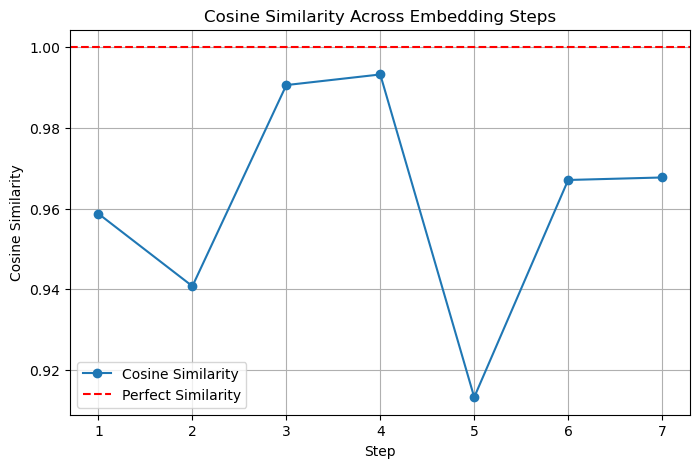

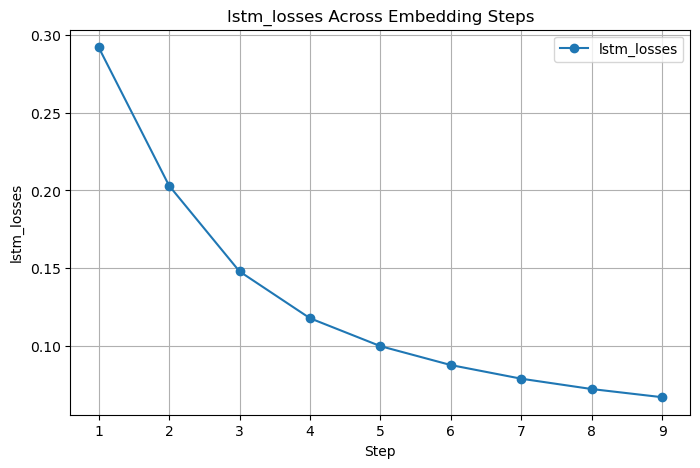

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = []
for i in range(len(embeddings) - 1):
    input_embedding = embeddings[i].reshape(1,1, -1)
    print(input_embedding.shape )
    target_embedding = embeddings[i + 1].reshape(1, -1)
    predicted_embedding=lstm_model.predict(input_embedding).reshape(1,-1) 
    similarity = cosine_similarity(predicted_embedding, target_embedding)
    cosine_similarities.append(similarity[0][0])
    print(f"Cosine similarity for step {i + 1}: {similarity[0][0]:.4f}")

    

import matplotlib.pyplot as plt

# Visualize cosine similarities
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cosine_similarities) + 1), cosine_similarities, marker='o', label='Cosine Similarity')
plt.xlabel('Step')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Across Embedding Steps')
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect Similarity')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Visualize cosine similarities
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(lstm_losses) + 1), lstm_losses, marker='o', label='lstm_losses')
plt.xlabel('Step')
plt.ylabel('lstm_losses')
plt.title('lstm_losses Across Embedding Steps')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# [-0.74124781 -0.39675981 -0.14175688  0.67100931  0.10559751 -0.25036786
#   0.80581897  0.32657646  0.2349149  -0.99249483]
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Assuming final_embedding is already computed and is of shape (768, 1)
# Reshape the final embedding to 1D if needed
final_embedding = final_embedding_lstm.reshape(1, -1)  # (1, 768)

# Assuming 'combined_embedding' in the DataFrame is a list or array of shape (768,)
# Convert the combined embeddings to a 2D array (each embedding will be a row of size 768)
embeddings_df = np.array([ast.literal_eval(embed) for embed in df['combined_embedding']])

# Compute cosine similarities between the final embedding and each row of the embeddings in the DataFrame
cos_similarities = cosine_similarity(final_embedding, embeddings_df)

# Get the indices of the top 5 most similar embeddings
top_5_indices = np.argsort(cos_similarities[0])[::-1][:8]  # Sorting in descending order and selecting top 5

# Retrieve the corresponding video_ids or any other relevant information from the df
top_5_video_ids = df.iloc[top_5_indices]['video_id'].values
top_5_similarities = cos_similarities[0][top_5_indices]

# Print the top 5 matches
for idx, (video_id, similarity) in enumerate(zip(top_5_video_ids, top_5_similarities)):
    print(f"Match {idx + 1}:")
    print(f"Video ID: {video_id}")
    print(f"Cosine similarity: {similarity:.4f}")
    print("-" * 30)


Match 1:
Video ID: mhIdrDx-4HU
Cosine similarity: 0.9901
------------------------------
Match 2:
Video ID: mhIdrDx-4HU
Cosine similarity: 0.9901
------------------------------
Match 3:
Video ID: mhIdrDx-4HU
Cosine similarity: 0.9901
------------------------------
Match 4:
Video ID: 2qsZ8jT-Mfk
Cosine similarity: 0.9901
------------------------------
Match 5:
Video ID: 2qsZ8jT-Mfk
Cosine similarity: 0.9901
------------------------------
Match 6:
Video ID: 2qsZ8jT-Mfk
Cosine similarity: 0.9901
------------------------------
Match 7:
Video ID: 2qsZ8jT-Mfk
Cosine similarity: 0.9901
------------------------------
Match 8:
Video ID: e_a5i20Xfvo
Cosine similarity: 0.9900
------------------------------


In [ ]:
df['video_id'].duplicated().sum()

4446

['Aw6GkiCvcWs', 'kTny1iFuTh0', 'rn6R4ncd2OU', '_K0sfcUp3ew', '-JP-zoBLyWE', 'NfZ96LgkCUI', 'AuRv0Vu55nA', 'LITlLW9bYNs']
Embeddings shape after extraction: (9, 768)
Embeddings shape: (9, 768)
Initial embedding: [-0.80943596 -0.47267896 -0.27824128  0.52083296  0.11249123 -0.18286908
  0.70619047  0.40365812  0.12661737 -0.99996591]
Step 1: Loss = 0.2943
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
Embedding after Step 1: [-0.03225317 -0.00267399  0.01803721 -0.0427278   0.00752276  0.03634735
  0.02242918  0.01228678 -0.04551263 -0.01911191]
Step 1: Loss = 0.2902
Step 2: Loss = 0.2852
Step 3: Loss = 0.2789
Step 4: Loss = 0.2714
Step 5: Loss = 0.2619
Step 6: Loss = 0.2513
Step 7: Loss = 0.2395
Step 8: Loss = 0.2270
Step 1: Loss = 0.2143
Step 2: Loss = 0.2018
Step 3: Loss = 0.1900
Step 4: Loss = 0.1792
Step 5: Loss = 0.1693
Step 6: Loss = 0.1602
Step 7: Loss = 0.1517
Step 8: Loss = 0.1437
Step 1: Loss = 0.1363
Step 2: Loss = 0.1295
Step 3: Loss = 0.1234
Step 4: Loss = 0.1179
Step 5: Loss = 0.1

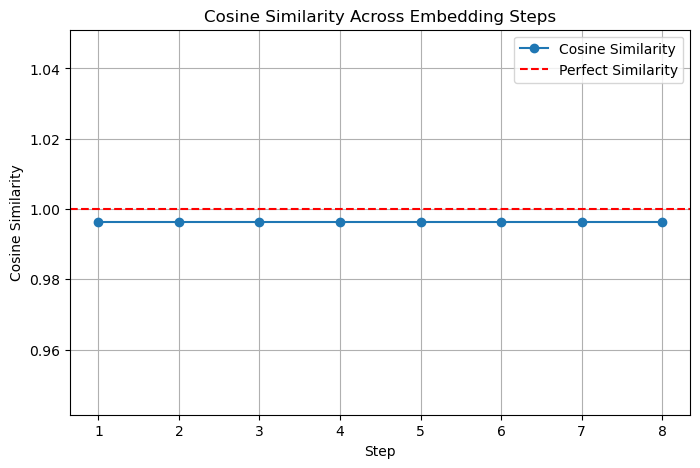

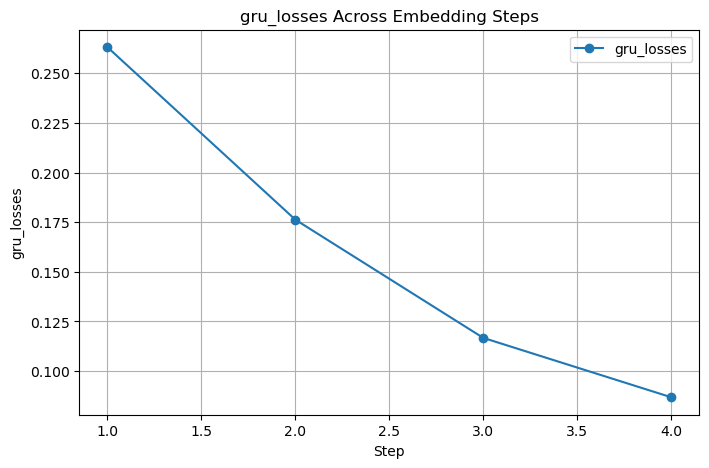

In [66]:
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import random

# Define the GRU model
def create_model(input_dim):
    model = Sequential([
        GRU(128, input_shape=(1, input_dim), return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GRU(64, return_sequences=False),
        Dense(256, activation='relu'),
        Dense(input_dim, activation='linear')  # Adjust output layer activation if needed
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
    return model    

def get_video_embeddings(video_ids, df):
    embeddings = []
    
    for video_id in video_ids:
        if video_id in df['video_id'].values:
            embedding = df[df['video_id'] == 'RswkyHO6zkM']['combined_embedding'].iloc[0]

            embedding_array = np.array(ast.literal_eval(embedding))

            # Now reshape the array to (768,)
            embedding = embedding_array.reshape(768,)
            
            if len(embedding) > 0:
               
                # Check the shape of the individual embedding
                # print(f"Embedding for video_id {video_id}: {embedding.shape}")  # Debugging the shape of each embedding
                
                # Ensure that embedding is a 1D array of length 768
                if embedding.shape != (768,):
                    print(f"Warning: Embedding for video_id {video_id} has unexpected shape {embedding.shape}.")
                    embedding = np.ones(768)  # Replace with zero vector if shape is not (768,)
                
                embeddings.append(embedding)
            else:
                print(f"Embedding not found for video_id {video_id}.")
                embeddings.append(np.zeros(768))  # If embedding is missing, append zero vector
        else:
            print(f"Video ID {video_id} not found in DataFrame.")
            embeddings.append(np.ones(768))  # If video_id not found, append zero vector
    
    embeddings = np.array(embeddings)

    # Check if embeddings have the correct shape
    print("Embeddings shape after extraction:", embeddings.shape)  # Should be (N, 768)

    # Validate that embeddings have the correct shape
    if embeddings.shape[1] != 768:
        raise ValueError(f"Expected embedding dimension of 768, but got {embeddings.shape[1]}.")

    return embeddings

# Iteratively update embeddings
def iterative_embedding_update(model, embeddings, alpha=0.5):
    current_embedding = embeddings[0]  # Always start with the first embedding
    print("Initial embedding:", current_embedding[:10])  # Debug: Print first 10 values of initial embedding
    for i in range(1, len(embeddings)):
        input_embedding = current_embedding.reshape(1, 1, -1)  # Reshape for GRU input
        predicted_embedding = model.predict(input_embedding)
        # Update the embedding using a weighted average of prediction and next embedding
        current_embedding = alpha * predicted_embedding[0] + (1 - alpha) * embeddings[i]
    return current_embedding


# Assuming these are the video IDs
video_ids =['ZiULxLLP32s', 'Aw6GkiCvcWs', '_K0sfcUp3ew', 'NfZ96LgkCUI',
       'LITlLW9bYNs', 'rn6R4ncd2OU', 'AuRv0Vu55nA', 'kTny1iFuTh0',
       '-JP-zoBLyWE']


# Randomly select 8 video IDs from the list
random_video_ids = random.sample(video_ids, 8)

# Print the selected video IDs
print(random_video_ids)

# Assuming df is already defined and contains video IDs and combined embeddings
embeddings = get_video_embeddings(video_ids, df)

# Verify embedding dimensions
print("Embeddings shape:", embeddings.shape)  # Should be (5, 768)

# Create the model
embedding_dim = embeddings.shape[1]  # This should be 768
gru_model = create_model(embedding_dim)

# Training and showing embeddings after each epoch
print("Initial embedding:", embeddings[0][:10])  # Show the first embedding before training

# First epoch: Train to match the first embedding
initial_embedding = embeddings[0].reshape(1, 1, -1)
target_embedding = embeddings[1].reshape(1, -1)
loss = gru_model.train_on_batch(initial_embedding, target_embedding)
print(f"Step 1: Loss = {loss:.4f}")
print(f"Embedding after Step 1: {gru_model.predict(initial_embedding).flatten()[:10]}")  # First prediction


gru_losses = []
for epoch in range(1,5):  # Reduced epochs for demonstration
    epoch_loss = 0
    for i in range(len(embeddings) - 1):  # Train on pairs
        input_embedding = embeddings[i].reshape(1, 1, -1)
        target_embedding = embeddings[i + 1].reshape(1, -1)
        loss = gru_model.train_on_batch(input_embedding, target_embedding)
        epoch_loss += loss
        print(f"Step {i + 1}: Loss = {loss:.4f}")
    gru_losses.append(epoch_loss / (len(embeddings) - 1))  # Average loss for the epoch


# After training, print final embedding
final_embedding_gru = iterative_embedding_update(gru_model, embeddings, alpha=0.5)
print("Final updated embedding shape:", final_embedding.shape)
print("Final updated embedding (sample):", final_embedding[:10])  # Display first 10 values

from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = []
for i in range(len(embeddings) - 1):
    input_embedding = embeddings[i].reshape(1,1, -1)
    print(input_embedding.shape )
    target_embedding = embeddings[i + 1].reshape(1, -1)
    predicted_embedding=gru_model.predict(input_embedding).reshape(1,-1) 
    similarity = cosine_similarity(predicted_embedding, target_embedding)
    cosine_similarities.append(similarity[0][0])
    print(f"Cosine similarity for step {i + 1}: {similarity[0][0]:.4f}")

    

import matplotlib.pyplot as plt

# Visualize cosine similarities
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cosine_similarities) + 1), cosine_similarities, marker='o', label='Cosine Similarity')
plt.xlabel('Step')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Across Embedding Steps')
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect Similarity')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Visualize cosine similarities
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(gru_losses) + 1), gru_losses, marker='o', label='gru_losses')
plt.xlabel('Step')
plt.ylabel('gru_losses')
plt.title('gru_losses Across Embedding Steps')
plt.legend()
plt.grid(True)
plt.show()

Initial embedding: [-0.80943596 -0.47267896 -0.27824128  0.52083296  0.11249123 -0.18286908
  0.70619047  0.40365812  0.12661737 -0.99996591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Initial embedding: [-0.80943596 -0.47267896 -0.27824128  0.52083296  0.11249123 -0.18286908
  0.70619047  0.40365812  0.12661737 -0.99996591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


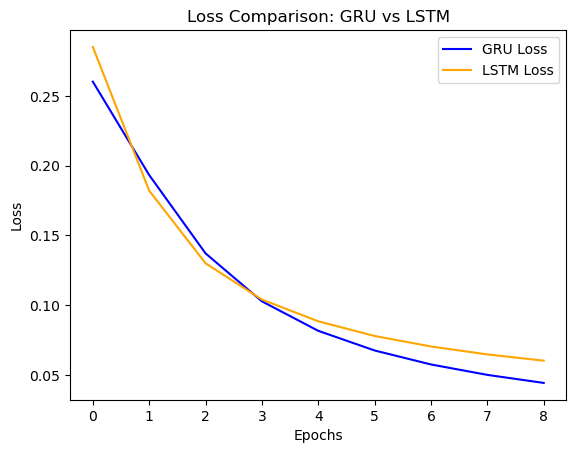

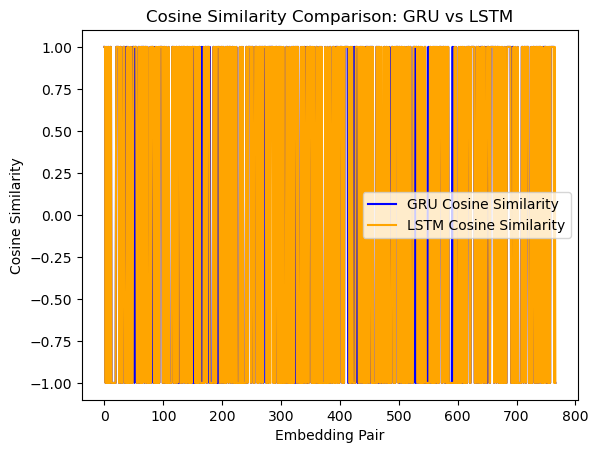

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Function to plot the loss curve for both models
def plot_loss_comparison(gru_losses, lstm_losses):
    plt.plot(gru_losses, label='GRU Loss', color='blue')
    plt.plot(lstm_losses, label='LSTM Loss', color='orange')
    plt.title('Loss Comparison: GRU vs LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to calculate cosine similarities for embedding comparison
def plot_cosine_similarity(gru_embeddings, lstm_embeddings):
    gru_similarities = [cosine_similarity(gru_embeddings[i].reshape(1, -1), gru_embeddings[i + 1].reshape(1, -1))[0][0] for i in range(len(gru_embeddings) - 1)]
    lstm_similarities = [cosine_similarity(lstm_embeddings[i].reshape(1, -1), lstm_embeddings[i + 1].reshape(1, -1))[0][0] for i in range(len(lstm_embeddings) - 1)]
    
    plt.plot(gru_similarities, label='GRU Cosine Similarity', color='blue')
    plt.plot(lstm_similarities, label='LSTM Cosine Similarity', color='orange')
    plt.title('Cosine Similarity Comparison: GRU vs LSTM')
    plt.xlabel('Embedding Pair')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.show()


# Final embeddings after training (for GRU and LSTM)
gru_final_embeddings = iterative_embedding_update(gru_model, embeddings, alpha=0.5)
lstm_final_embeddings = iterative_embedding_update(lstm_model, embeddings, alpha=0.5)

# Visualize the loss comparison
plot_loss_comparison(gru_losses, lstm_losses)

# Visualize the cosine similarity comparison between GRU and LSTM final embeddings
plot_cosine_similarity(gru_final_embeddings, lstm_final_embeddings)


In [49]:
# [-0.74124781 -0.39675981 -0.14175688  0.67100931  0.10559751 -0.25036786
#   0.80581897  0.32657646  0.2349149  -0.99249483]
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Assuming final_embedding is already computed and is of shape (768, 1)
# Reshape the final embedding to 1D if needed
final_embedding = final_embedding_gru.reshape(1, -1)  # (1, 768)

# Assuming 'combined_embedding' in the DataFrame is a list or array of shape (768,)
# Convert the combined embeddings to a 2D array (each embedding will be a row of size 768)
embeddings_df = np.array([ast.literal_eval(embed) for embed in df['combined_embedding']])

# Compute cosine similarities between the final embedding and each row of the embeddings in the DataFrame
cos_similarities = cosine_similarity(final_embedding, embeddings_df)

# Get the indices of the top 5 most similar embeddings
top_5_indices = np.argsort(cos_similarities[0])[::-1][:8]  # Sorting in descending order and selecting top 5

# Retrieve the corresponding video_ids or any other relevant information from the df
top_5_video_ids = df.iloc[top_5_indices]['video_id'].values
top_5_similarities = cos_similarities[0][top_5_indices]

# Print the top 5 matches
for idx, (video_id, similarity) in enumerate(zip(top_5_video_ids, top_5_similarities)):
    print(f"Match {idx + 1}:")
    print(f"Video ID: {video_id}")
    print(f"Cosine similarity: {similarity:.4f}")
    print("-" * 30)


Match 1:
Video ID: RswkyHO6zkM
Cosine similarity: 0.9999
------------------------------
Match 2:
Video ID: SKytwnNvnaY
Cosine similarity: 0.9931
------------------------------
Match 3:
Video ID: N7wlXtY3NdI
Cosine similarity: 0.9931
------------------------------
Match 4:
Video ID: XbxsdbisXzU
Cosine similarity: 0.9919
------------------------------
Match 5:
Video ID: ZgjWOo7IqQY
Cosine similarity: 0.9914
------------------------------
Match 6:
Video ID: p3e7yhz-akk
Cosine similarity: 0.9910
------------------------------
Match 7:
Video ID: gs0jpvNaqhs
Cosine similarity: 0.9909
------------------------------
Match 8:
Video ID: YGCnbiQVn_w
Cosine similarity: 0.9904
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


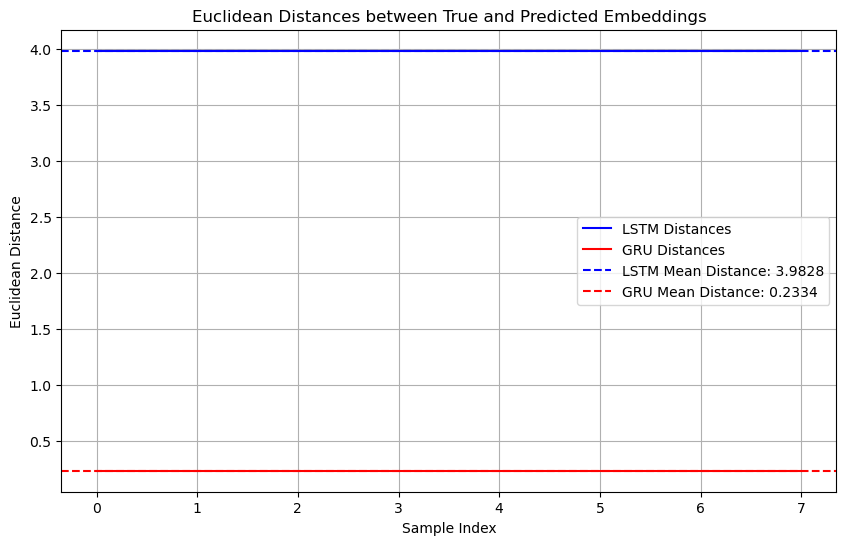

(3.982844905093667, 0.23341909495584617)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `embeddings` is a list of true embeddings from the dataset
# and `lstm_model` and `gru_model` are the trained models

# Placeholder for predicted and true embeddings
lstm_euclidean_distances = []
gru_euclidean_distances = []

for i in range(len(embeddings) - 1):
    input_embedding = embeddings[i].reshape(1, 1, -1)  # Reshape for model input
    true_embedding = embeddings[i + 1]  # Next embedding in the sequence

    # Predictions
    lstm_predicted_embedding = lstm_model.predict(input_embedding)
    gru_predicted_embedding = gru_model.predict(input_embedding)

    # Compute Euclidean Distance
    lstm_distance = np.linalg.norm(true_embedding - lstm_predicted_embedding.flatten())
    gru_distance = np.linalg.norm(true_embedding - gru_predicted_embedding.flatten())

    lstm_euclidean_distances.append(lstm_distance)
    gru_euclidean_distances.append(gru_distance)

# Calculate mean distances as overall metrics
lstm_mean_distance = np.mean(lstm_euclidean_distances)
gru_mean_distance = np.mean(gru_euclidean_distances)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(lstm_euclidean_distances, label='LSTM Distances', color='blue')
plt.plot(gru_euclidean_distances, label='GRU Distances', color='red')
plt.axhline(y=lstm_mean_distance, color='blue', linestyle='--', label=f'LSTM Mean Distance: {lstm_mean_distance:.4f}')
plt.axhline(y=gru_mean_distance, color='red', linestyle='--', label=f'GRU Mean Distance: {gru_mean_distance:.4f}')
plt.title('Euclidean Distances between True and Predicted Embeddings')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.grid(True)
plt.show()

# Output the mean distances
lstm_mean_distance, gru_mean_distance
